In [1]:
import numpy as np
import pandas as pd
import plotly.offline as py
import plotly.graph_objects as go
import datashader as ds
import datashader.transfer_functions as tf
import plotly.express as px
import matplotlib.image as mpimg
import pywt

from colorcet import fire
from plotly.subplots import make_subplots

# 加载确诊病例
confirmed = pd.read_csv(
    "time_series_19-covid-Confirmed_archived_0325.csv")
# 提取中国确诊病例
confirmed_China = confirmed[confirmed['Country/Region'] == 'China']
# 查看前5条数据
confirmed_China.head(5)

Province/State Country/Region      Lat      Long  1/22/20  1/23/20  \
154          Hubei          China  30.9756  112.2707      444      444   
158      Guangdong          China  23.3417  113.4244       26       32   
159          Henan          China  33.8820  113.6140        5        5   
160       Zhejiang          China  29.1832  120.0934       10       27   
161          Hunan          China  27.6104  111.7088        4        9   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  3/14/20  3/15/20  3/16/20  \
154      549      761     1058     1423  ...    67790    67794    67798   
158       53       78      111      151  ...     1356     1360     1361   
159        9       32       83      128  ...     1273     1273     1273   
160       43       62      104      128  ...     1227     1231     1231   
161       24       43       69      100  ...     1018     1018     1018   

     3/17/20  3/18/20  3/19/20  3/20/20  3/21/20  3/22/20  3/23/20  
154    67799    67800    67800    67800    67800    67800  67800.0  
158     1364     1370     1378     1395     1400     1407   1413.0  
159     1273     1273     1273     1273     1273     1273   1274.0  
160     1232     1232     1233     1234     1236     1237   1238.0  
161     1018     1018     1018     1018     1018     1018   1018.0  

[5 rows x 66 columns]

In [3]:
py.init_notebook_mode(connected=True)
fig = go.Figure()
for index, row in confirmed_China.iterrows():
    fig.add_trace(go.Scatter(x = row.index[4:], y = list(row)[4:], name = row[0], line=dict(width=4)))
fig.update_layout(title='China Province Confirmed Case Number',
                   xaxis_title='Date',
                   yaxis_title='Cases')
py.iplot(fig)

In [4]:
fig = go.Figure()
for index, row in confirmed_China.iterrows():
    growing_number = []
    for i in range(len(row[4:]) - 1):
        growing_number.append(row[4 + i + 1] - row[4 + i])
    fig.add_trace(go.Scatter(x = row.index[5:], y = growing_number, name = row[0], line=dict(width=4)))
fig.update_layout(title='China Province Confirmed Case Growing Number',
                   xaxis_title='Date',
                   yaxis_title='Cases')
py.iplot(fig)

In [5]:
fig = go.Figure()
for index, row in confirmed_China.iterrows():
    growing_rate = []
    for i in range(len(row[4:]) - 1):
        if row[4 + i] != 0:
            growing_rate.append((row[4 + i + 1] - row[4 + i]) / row[4 + i])
        else:
            growing_rate.append(0)
    fig.add_trace(go.Scatter(x = row.index[5:], y = growing_rate, name = row[0], line=dict(width=4)))
fig.update_layout(title='China Province Confirmed Case Growing Rate',
                   xaxis_title='Date',
                   yaxis_title='Cases')
py.iplot(fig)


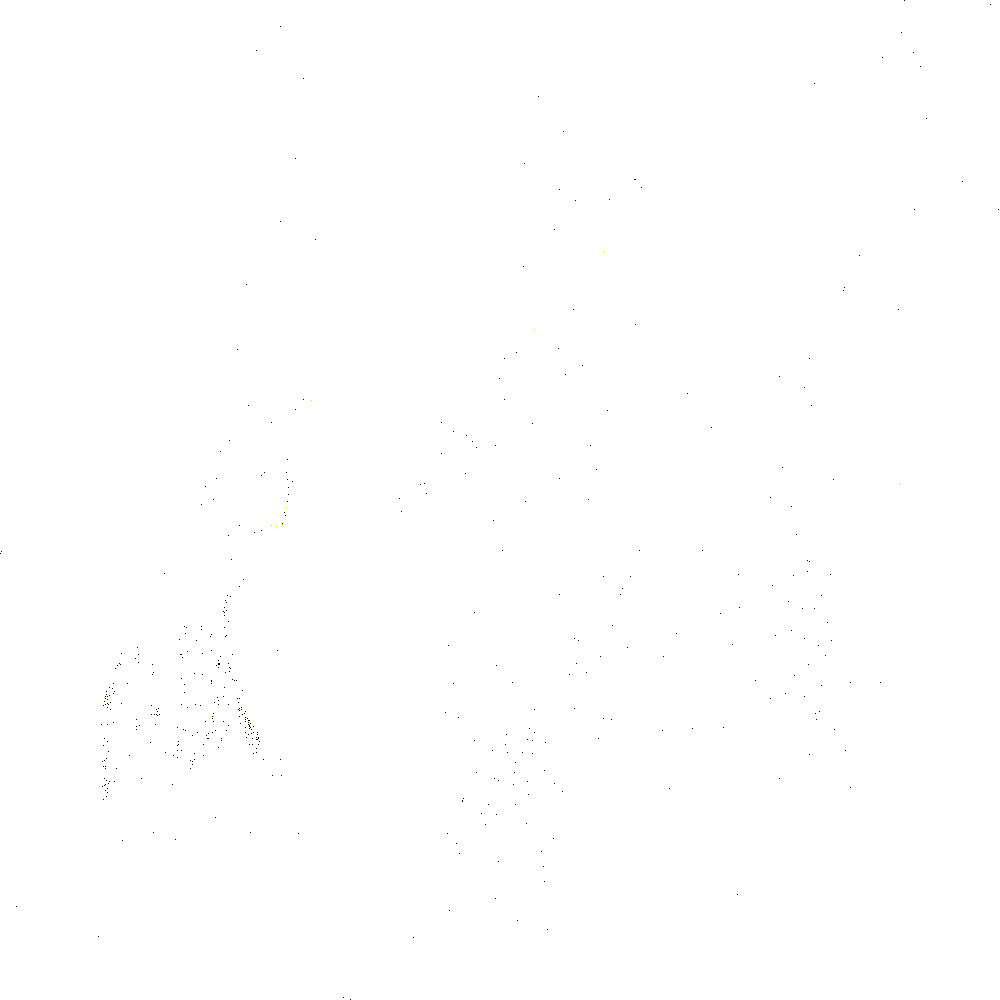

In [6]:
cvs = ds.Canvas(plot_width=1000, plot_height=1000)
agg = cvs.points(confirmed, x='Long', y='Lat')
coords_lat, coords_lon = agg.coords['Lat'].values, agg.coords['Long'].values
coordinates = [[coords_lon[0], coords_lat[0]],
               [coords_lon[-1], coords_lat[0]],
               [coords_lon[-1], coords_lat[-1]],
               [coords_lon[0], coords_lat[-1]]]
img = tf.shade(agg, cmap=fire)[::-1].to_pil()
fig = px.scatter_mapbox(confirmed, lat="Lat", lon="Long", hover_name="Province/State", hover_data=["Country/Region"],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=400)
fig.update_layout(mapbox_style="carto-darkmatter",
                 mapbox_layers = [
                {
                    "sourcetype": "image",
                    "source": img,
                    "coordinates": coordinates
                }]
)
fig.show()

In [7]:
# 世界各国确诊时序分析
time_series = pd.read_csv('time_series_covid19_confirmed_global.csv')
confirmed_whole = time_series.groupby('Country/Region').sum()
confirmed_whole = confirmed_whole.drop(columns=['Lat', 'Long'])
fig = go.Figure()
for index, row in confirmed_whole.iterrows():
    fig.add_trace(go.Scatter(x = row.index[4:], y = list(row)[4:], name = row.name, line=dict(width=4)))
fig.update_layout(title='Whole World Confirmed Case Number',
                   xaxis_title='Date',
                   yaxis_title='Cases')
py.iplot(fig)

In [8]:
infection_the_world = confirmed_whole[confirmed_whole.columns[34:]]
fig = make_subplots(rows=2, cols=1, vertical_spacing=0.3, specs=[[{"type": "scatter"}], [{"type": "scatter"}]])
for index, row in infection_the_world.iterrows():
    slope = []
    accelarate = []
    for i in range(len(row) - 1):
        slope.append(row[i + 1] - row[i])
    for j in range(len(slope) - 1):
        accelarate.append(slope[j + 1] - slope[j])
    fig.add_trace(go.Scatter(x = row.index[1:], y = slope, name = row.name, line=dict(width=4)), row=1, col=1)
    fig.add_trace(go.Scatter(x = row.index[2:], y = accelarate, name = row.name, line=dict(width=4)), row=2, col=1)
fig.update_layout(title_text='World Confirmed Case Accelaration', height=600)
py.iplot(fig)

In [45]:
"""
使用关联网络分析国家间病毒传播
"""

# 基于DCCA生成去趋势互相关矩阵
# Return sliding windows
def sliding_window(xx,k):
    # Function to generate boxes given dataset(xx) and box size (k)
    import numpy as np

    # generate indexes! O(1) way of doing it :)
    idx = np.arange(k)[None, :]+np.arange(len(xx)-k+1)[:, None]
    return xx[idx],idx

def compute_dpcca_others(cdata,k):
    # Input: cdata(nsamples,nvars), k: time scale for dpcca
    # Output: dcca, dpcca, corr, partialCorr
    #
    # Date(last modification): 02/15/2018
    # Author: Jaime Ide (jaime.ide@yale.edu)
    
    # Code distributed "as is", in the hope that it will be useful, but WITHOUT ANY WARRANTY;
    # without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
    # See the GNU General Public License for more details.
    
    import numpy as np
    from numpy.matlib import repmat
    
    # Define
    nsamples,nvars = cdata.shape

    # Cummulative sum after removing mean
    #cdata = signal.detrend(cdata,axis=0) # different from only removing the mean...
    cdata = cdata-cdata.mean(axis=0)
    xx = np.cumsum(cdata,axis=0)
    
    F2_dfa_x = np.zeros(nvars)
    allxdif = []
    # Get alldif and F2_dfa
    for ivar in range(nvars): # do for all vars
        xx_swin , idx = sliding_window(xx[:,ivar],k)
        nwin = xx_swin.shape[0]
        b1, b0 = np.polyfit(np.arange(k),xx_swin.T,deg=1) # linear fit (UPDATE if needed)
        
        #x_hat = [[b1[i]*j+b0[i] for j in range(k)] for i in range(nwin)] # Slower version
        x_hatx = repmat(b1,k,1).T*repmat(range(k),nwin,1) + repmat(b0,k,1).T
    
        # Store differences to the linear fit
        xdif = xx_swin-x_hatx
        allxdif.append(xdif)
        # Eq.4
        F2_dfa_x[ivar] = (xdif**2).mean()
    # Get the DCCA matrix
    dcca = np.zeros([nvars,nvars])
    for i in range(nvars): # do for all vars
        for j in range(nvars): # do for all vars
            # Eq.5 and 6
            F2_dcca = (allxdif[i]*allxdif[j]).mean()
            # Eq.1: DCCA
            dcca[i,j] = F2_dcca / np.sqrt(F2_dfa_x[i] * F2_dfa_x[j])   
    
    # Get DPCCA
    C = np.linalg.inv(dcca)
    
    # (Clear but slow version)
    #dpcca = np.zeros([nvars,nvars])
    #for i in range(nvars):
    #    for j in range(nvars):
    #        dpcca[i,j] = -C[i,j]/np.sqrt(C[i,i]*C[j,j])
    
    # DPCCA (oneliner version)
    mydiag = np.sqrt(np.abs(np.diag(C)))
    dpcca = (-C/repmat(mydiag,nvars,1).T)/repmat(mydiag,nvars,1)+2*np.eye(nvars)
    
    # Include correlation and partial corr just for comparison ;)
    # Compute Corr
    corr = np.corrcoef(cdata.T)
    # Get parCorr
    cov = np.cov(cdata.T)
    C0 = np.linalg.inv(cov)
    mydiag = np.sqrt(np.abs(np.diag(C0)))
    parCorr = (-C0/repmat(mydiag,nvars,1).T)/repmat(mydiag,nvars,1)+2*np.eye(nvars)
    
    return corr,parCorr,dcca,dpcca

In [51]:
# 使用Gephi过滤生成中国各省的相关网络
# confirmed_China = confirmed_China.set_index('Province/State')
# confirmed_China = confirmed_China.drop(columns=['Country/Region', 'Lat', 'Long'])
Original_Matrix = pd.DataFrame(columns = confirmed_China.index, dtype='float64')
for index, row in confirmed_China.iterrows():
    slope = []
    for i in range(len(row) - 1):
        slope.append(row[i + 1] - row[i])
    for j in range(len(slope) - 1):
        Original_Matrix.loc[j, index] = slope[j + 1] - slope[j]
original_matrix = Original_Matrix.values
original_matrix


Empty DataFrame
Columns: [Hubei, Guangdong, Henan, Zhejiang, Hunan, Anhui, Jiangxi, Shandong, Jiangsu, Chongqing, Sichuan, Heilongjiang, Beijing, Shanghai, Hebei, Fujian, Guangxi, Shaanxi, Yunnan, Hainan, Guizhou, Tianjin, Shanxi, Gansu, Hong Kong, Liaoning, Jilin, Xinjiang, Inner Mongolia, Ningxia, Qinghai, Macau, Tibet]
Index: []

[0 rows x 33 columns]


array([[105.,  15.,   4., ...,   0.,  -1.,   0.],
       [107.,   4.,  19., ...,   1.,   0.,   0.],
       [ 85.,   8.,  28., ...,  -1.,   3.,   0.],
       ...,
       [  0., -12.,   0., ...,   0.,   1.,   0.],
       [  0.,   2.,   0., ...,   0.,   1.,   0.],
       [  0.,  -1.,   1., ...,   0.,   2.,   0.]])

In [47]:
corr,parCorr,dcca, dpcca = compute_dpcca_others(original_matrix, 7)
df_DCCA = pd.DataFrame(data=dcca, index=confirmed_China.index, columns=confirmed_China.index, dtype='float64')
df_DCCA.to_csv('Correlation_DCCA_China.csv')

In [49]:
# 使用Gephi过滤生成全球各国相关网络
Original_Matrix = pd.DataFrame(columns = confirmed_whole.index, dtype='float64')
for index, row in confirmed_whole.iterrows():
    slope = []
    for i in range(len(row) - 1):
        slope.append(row[i + 1] - row[i])
    for j in range(len(slope) - 1):
        Original_Matrix.loc[j, index] = slope[j + 1] - slope[j]
Original_Matrix = Original_Matrix.values
corr,parCorr,dcca, dpcca = compute_dpcca_others(Original_Matrix, 7)
df_DCCA = pd.DataFrame(data=dcca, index=confirmed_whole.index, columns=confirmed_whole.index, dtype='float64')
df_DCCA.to_csv('Correlation_DCCA.csv')

In [61]:
"""
使用小波分析寻找COVID19传播的规律
"""

# 特征提取
A2 = pd.DataFrame(index=confirmed_whole.index, columns=[i for i in range(53)], dtype=np.float_)
D1 = pd.DataFrame(index=confirmed_whole.index, columns=[i for i in range(100)], dtype=np.float_)
D2 = pd.DataFrame(index=confirmed_whole.index, columns=[i for i in range(53)], dtype=np.float_)
Original_Matrix = pd.DataFrame(columns = confirmed_whole.index, dtype=np.float_)
for index, row in confirmed_whole.iterrows():
    slope = []
    for i in range(len(row) - 1):
        slope.append(row[i + 1] - row[i])
    for j in range(len(slope) - 1):
        Original_Matrix.loc[j, index] = slope[j + 1] - slope[j]
        
for country in Original_Matrix.columns:
    a2, d2, d1 = pywt.wavedec(list(Original_Matrix[country]), 'db4', mode = 'sym', level = 2)
    A2.loc[country] = a2
    D2.loc[country] = d2
    D1.loc[country] = d1

In [62]:
# 可视化
fig = make_subplots(rows=3, cols=1, vertical_spacing=0.1, specs=[[{"type": "scatter"}], [{"type": "scatter"}], [{"type": "scatter"}]])
for index, item in A2.iterrows():
    fig.add_trace(go.Scatter(y = item, name = item.name, line=dict(width=4)), row=1, col=1)
for index, item in D2.iterrows():
    fig.add_trace(go.Scatter(y = item, name = item.name, line=dict(width=4)), row=2, col=1)
for index, item in D1.iterrows():
    fig.add_trace(go.Scatter(y = item, name = item.name, line=dict(width=4)), row=3, col=1)   
fig.update_layout(title='Wavelets', height=600)
py.iplot(fig)